In [20]:
import sys
print(sys.executable)

import pandas as pd
import matplotlib.pyplot as plt

ruta_csv = "../data/camiones_mina_mantenimiento.csv"
df = pd.read_csv(ruta_csv, parse_dates=["fecha_inicio", "fecha_termino"])
df.head()


/Users/hugobaghetti/Desktop/PROYECTOS/Proyecto Mineria/.venv/bin/python


,id_ot,equipo,fecha_inicio,fecha_termino,tipo_mantencion,sistema,causa_raiz,horas_paro,horas_trabajadas_periodo,criticidad_equipo,faena,mes
0,OT00001,CAEX-103,2025-03-08 10:31:15,2025-03-08 23:01:01,Correctiva,Transmisión,Rotura de neumático,12.50,207.8,Media,Faena Atacama Norte,2025-03
1,OT00002,CAEX-102,2025-04-27 12:57:12,2025-04-28 02:45:41,Preventiva,Hidráulico,Sobrecalentamiento motor,13.81,259.5,Media,Faena Atacama Norte,2025-04
2,OT00003,CAEX-105,2025-01-07 09:28:05,2025-01-07 11:25:40,Correctiva,Hidráulico,Rotura de neumático,1.96,315.1,Alta,Faena Atacama Norte,2025-01
3,OT00004,CAEX-105,2025-02-04 11:31:49,2025-02-04 23:49:40,Correctiva,Hidráulico,Falla eléctrica en tablero,12.30,277.2,Media,Faena Atacama Norte,2025-02
4,OT00005,CAEX-104,2025-04-17 23:13:29,2025-04-18 01:42:37,Preventiva,Hidráulico,Rotura de neumático,2.49,210.1,Media,Faena Atacama Norte,2025-04


In [21]:
# 2. Exploración rápida

print("Filas:", len(df))
print("\nColumnas:", df.columns.tolist())

print("\nTipos de datos:")
print(df.dtypes)

print("\nResumen estadístico de horas de paro:")
print(df["horas_paro"].describe())

print("\nValores únicos de algunos campos clave:")
print("Equipos:", df["equipo"].unique())
print("Meses:", df["mes"].unique())
print("Tipo mantención:", df["tipo_mantencion"].unique())
print("Sistemas:", df["sistema"].unique())


Filas: 150

Columnas: ['id_ot', 'equipo', 'fecha_inicio', 'fecha_termino', 'tipo_mantencion', 'sistema', 'causa_raiz', 'horas_paro', 'horas_trabajadas_periodo', 'criticidad_equipo', 'faena', 'mes']

Tipos de datos:
id_ot                               object
equipo                              object
fecha_inicio                datetime64[ns]
fecha_termino               datetime64[ns]
tipo_mantencion                     object
sistema                             object
causa_raiz                          object
horas_paro                         float64
horas_trabajadas_periodo           float64
criticidad_equipo                   object
faena                               object
mes                                 object
dtype: object

Resumen estadístico de horas de paro:
count    150.000000
mean       7.741067
std        4.508310
min        0.720000
25%        3.555000
50%        7.550000
75%       11.972500
max       15.680000
Name: horas_paro, dtype: float64

Valores únicos de algu

In [22]:
# 3. Cálculo de KPIs por equipo y mes

group_cols = ["equipo", "mes"]
grp = df.groupby(group_cols)

kpis = grp.apply(
    lambda g: pd.Series({
        "horas_paro_total": g["horas_paro"].sum(),
        "horas_trab_periodo": g["horas_trabajadas_periodo"].max(),
        "n_fallas": len(g)
    })
).reset_index()

# Horas disponibles = trabajadas + paro
kpis["horas_disponibles"] = kpis["horas_trab_periodo"] + kpis["horas_paro_total"]

# Disponibilidad
kpis["disponibilidad"] = kpis["horas_trab_periodo"] / kpis["horas_disponibles"]

# MTTR y MTBF
kpis["mttr"] = kpis["horas_paro_total"] / kpis["n_fallas"]
kpis["mtbf"] = kpis["horas_trab_periodo"] / kpis["n_fallas"]

kpis.head()


/var/folders/r2/bqf5dz2n0zv155m2zzn9m54h0000gn/T/ipykernel_59112/3104462473.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  kpis = grp.apply(


,equipo,mes,horas_paro_total,horas_trab_periodo,n_fallas,horas_disponibles,disponibilidad,mttr,mtbf
0,CAEX-101,2025-01,31.98,318.5,6.0,350.48,0.908754,5.3300,53.083333
1,CAEX-101,2025-02,19.93,305.0,5.0,324.93,0.938664,3.9860,61.000000
2,CAEX-101,2025-03,16.85,310.6,4.0,327.45,0.948542,4.2125,77.650000
3,CAEX-101,2025-04,8.97,251.9,2.0,260.87,0.965615,4.4850,125.950000
4,CAEX-101,2025-05,14.88,199.5,1.0,214.38,0.930591,14.8800,199.500000


In [23]:
# 3.1 Resumen por equipo en todo el periodo

kpis_equipo = kpis.groupby("equipo").agg({
    "disponibilidad": "mean",
    "mttr": "mean",
    "mtbf": "mean",
    "horas_paro_total": "sum"
}).reset_index()

kpis_equipo.sort_values("disponibilidad")




,equipo,disponibilidad,mttr,mtbf,horas_paro_total
1,CAEX-102,0.881694,9.858111,85.410833,233.52
2,CAEX-103,0.886010,9.179405,88.752143,171.06
7,CAEX-108,0.910446,7.503333,135.216667,164.17
6,CAEX-107,0.917590,8.044500,87.051667,122.15
4,CAEX-105,0.924053,7.013750,111.271032,146.52
5,CAEX-106,0.931385,6.457222,122.533333,124.47
0,CAEX-101,0.934838,7.049472,103.480556,120.82
3,CAEX-104,0.949430,6.217222,159.509722,78.45


In [24]:
# 3.2 Pareto de causas de falla (por horas de paro)

pareto_causas = (
    df.groupby("causa_raiz")["horas_paro"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

pareto_causas["porcentaje"] = (
    pareto_causas["horas_paro"] / pareto_causas["horas_paro"].sum() * 100
)

pareto_causas["porcentaje_acumulado"] = pareto_causas["porcentaje"].cumsum()

pareto_causas


,causa_raiz,horas_paro,porcentaje,porcentaje_acumulado
0,Rotura de neumático,222.24,19.139481,19.139481
1,Desgaste de frenos,209.59,18.050053,37.189535
2,Falla eléctrica en tablero,208.47,17.953598,55.143133
3,Fuga hidráulica,185.81,16.002101,71.145234
4,Sobrecalentamiento motor,174.02,14.986737,86.131971
5,Sensor defectuoso,161.03,13.868029,100.000000


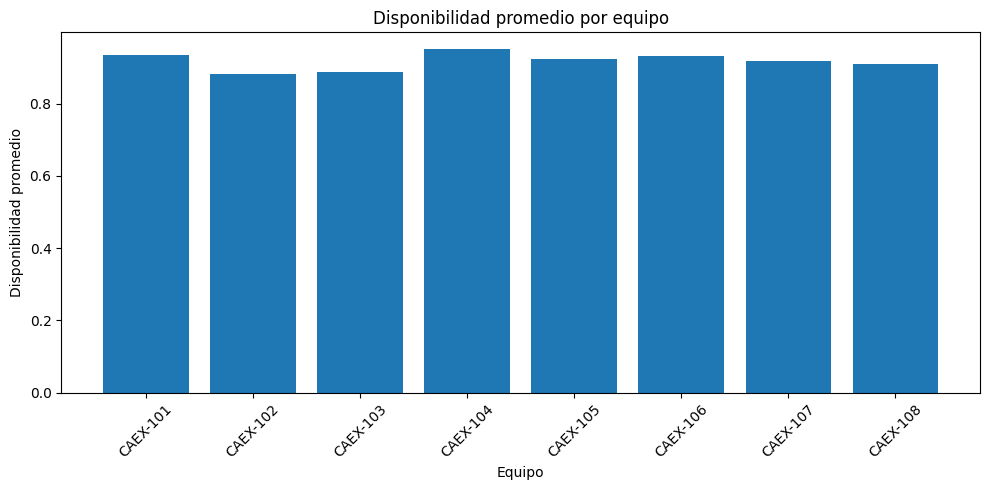

In [25]:
# 4.1 Disponibilidad promedio por equipo

plt.figure(figsize=(10, 5))
plt.bar(kpis_equipo["equipo"], kpis_equipo["disponibilidad"])
plt.xlabel("Equipo")
plt.ylabel("Disponibilidad promedio")
plt.title("Disponibilidad promedio por equipo")
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("../img/disponibilidad_promedio_por_equipo.png", dpi=150)

plt.show()


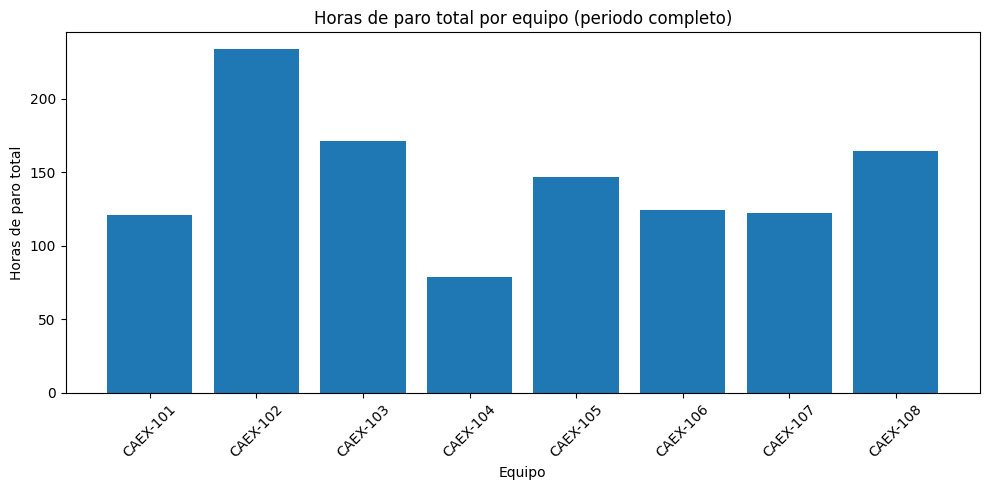

In [26]:
# 4.2 Horas de paro total por equipo

plt.figure(figsize=(10, 5))
plt.bar(kpis_equipo["equipo"], kpis_equipo["horas_paro_total"])
plt.xlabel("Equipo")
plt.ylabel("Horas de paro total")
plt.title("Horas de paro total por equipo (periodo completo)")
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("../img/horas_paro_total_por_equipo.png", dpi=150)

plt.show()



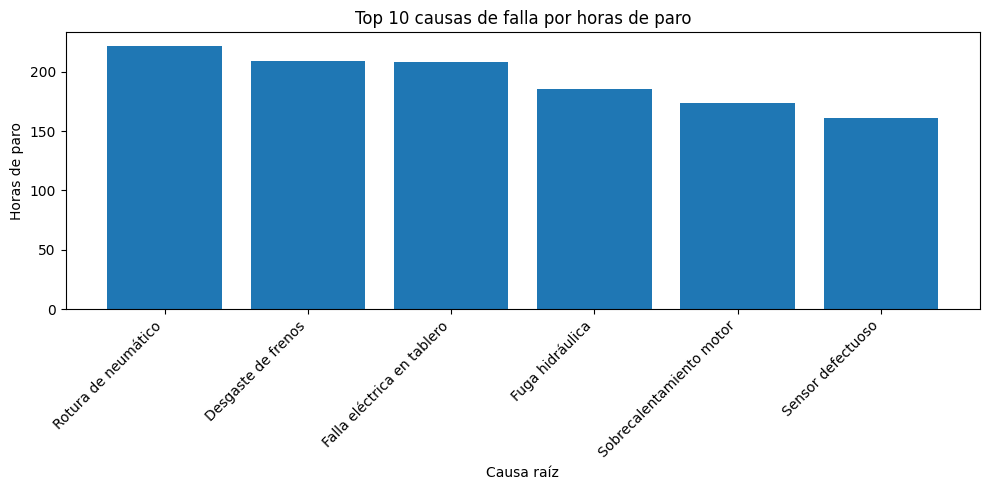

In [27]:
# 4.3 Top causas de falla por horas de paro

top_n = 10
top_causas = pareto_causas.head(top_n)

plt.figure(figsize=(10, 5))
plt.bar(top_causas["causa_raiz"], top_causas["horas_paro"])
plt.xlabel("Causa raíz")
plt.ylabel("Horas de paro")
plt.title(f"Top {top_n} causas de falla por horas de paro")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.savefig("../img/top_causas_falla.png", dpi=150)

plt.show()



In [19]:
# Resumen de disponibilidad de la flota

print(kpis_equipo["disponibilidad"].describe())


count    8.000000
mean     0.916931
std      0.023533
min      0.881694
25%      0.904337
50%      0.920822
75%      0.932248
max      0.949430
Name: disponibilidad, dtype: float64


In [18]:
# Top 3 equipos con menor disponibilidad

kpis_equipo.sort_values("disponibilidad").head(3)


,equipo,disponibilidad,mttr,mtbf,horas_paro_total
1,CAEX-102,0.881694,9.858111,85.410833,233.52
2,CAEX-103,0.886010,9.179405,88.752143,171.06
7,CAEX-108,0.910446,7.503333,135.216667,164.17


In [17]:
# ¿Qué porcentaje concentran las 3 principales causas?

top3 = pareto_causas.head(3)
porc_top3 = top3["porcentaje"].sum()
porc_top3


np.float64(55.14313272933962)

# 5. Conclusiones

- La disponibilidad promedio de la flota se sitúa en torno a **X–Y%**, con diferencias marcadas entre equipos.
- Algunos camiones concentran una proporción significativa de las horas de detención, lo que los convierte en candidatos prioritarios para iniciativas de mejora de confiabilidad.
- El análisis de Pareto muestra que un grupo reducido de causas raíz explica la mayor parte de las horas de paro, permitiendo focalizar acciones de mantenimiento sobre esos modos de falla.
- Los indicadores MTBF y MTTR entregan una base cuantitativa para comparar el desempeño de los equipos y evaluar el impacto de futuras iniciativas de mejora continua.
